In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
import glob
import tqdm
from labellines import *
import seaborn as sns
from astropy.io import fits
from scipy.stats import linregress
import math

divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 212.
nbins = 64
mmax = 10
nmax = 10

noise = 0.5
save_dir = "/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper"

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

In [2]:
def galaxy_morphology(file):
    
    def FindInc2(eta, A, B, C, D):
        
        if eta>0.5:
            inc=90
        else:
            # 1) Safe inverse argument (A can be negative)
            x = np.clip((eta - D) / A, -1.0, 1.0)

            # 2) Two branches from cos symmetry, all in radians
            a = np.arccos(x)                # in [0, pi]
            i1 = (a - C) / B
            i2 = (-a - C) / B

            # 3) Convert candidates to degrees
            cand = np.rad2deg(np.array([i1, i2]))

            # 4) Reduce by the period in degrees: P = 2π/|B| (then to degrees)
            P = np.rad2deg(2*np.pi / abs(B))
            cand = cand % P                 # map into one period

            # 5) Fold into [0, 180], then reflect >90 across 90 to get [0, 90]
            cand = np.where(cand > 180.0, cand - 180.0, cand)
            cand = np.where(cand > 90.0, 180.0 - cand, cand)

            # 6) Pick the candidate that best reproduces eta (keeps you on the line)
            def model(i_deg):
                return A*np.cos(B*np.deg2rad(i_deg) + C) + D

            errs = np.abs(model(cand) - eta)
            inc=float(cand[np.argmin(errs)])
        return inc
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    radius=h//4
    cx, cy = w//2, h//2
    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)
    x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
    y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    # Filter for positive intensities and R <= 80
    valid = (I > 0) & (R <= 80)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5


    x_edges = np.asarray(x_edges).ravel()
    y_edges = np.asarray(y_edges).ravel()

    if x_edges.size < 2 or y_edges.size < 2:
        raise ValueError("Need at least two edges along each axis.")

    # If reversed (common for image-style Y axes), flip them:
    if x_edges[0] > x_edges[-1]:
        x_edges = x_edges[::-1]
    if y_edges[0] > y_edges[-1]:
        y_edges = y_edges[::-1]

    # If they’re not strictly increasing (duplicates), uniquify & sort:
    x_edges = np.unique(x_edges)
    y_edges = np.unique(y_edges)
    D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
    D.img       = gray.T   
    D.x_edges   = x_edges
    D.y_edges   = y_edges
    D.x_centers = x_centers
    D.y_centers = y_centers

    mmax, nmax = 8, 10
    E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)
    
    c1 = E1.coscoefs; s1 = E1.sincoefs
   
    num = np.sqrt(sum((c1[2, n]**2 + s1[2, n]**2) for n in range(nmax)))
    den     = sum(abs(c1[0,n])            for n in range(nmax))

    eta_bt     = num/den
    A=-0.289256915274715
    B=-1.7006080841260558
    C=6.54207283791996
    D=0.34764087089364026
    
    A=-0.30845928737374684
    B=-1.6564105427131928
    C=6.430938401182824

    D=0.3145522357466893
    
    A=0.27262716014051763 
    B=-1.8397445743459468 
    C=3.3452301250356076 
    D=0.27926458537922233
    inc_bt=FindInc2(eta_bt,A,B,C,D)

    PA=90+(np.arctan2(s1[2,0],c1[2,0])* 180/np.pi)/2

    return inc_bt, PA, galaxy_name
    
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('gfits3/*.fits.fz')

for idx, file in enumerate(fits_files):
    A=galaxy_morphology(file)
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1]) 
    print(f"Processed {A[2]}, ID {idx}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed gfits3/NGC5289, ID 0: Inc=32.36, PA=99.43
Processed gfits3/NGC6186, ID 1: Inc=40.02, PA=58.08
Processed gfits3/NGC3310, ID 2: Inc=25.33, PA=4.16
Processed gfits3/NGC2893, ID 3: Inc=25.02, PA=158.45
Processed gfits3/NGC2776, ID 4: Inc=20.30, PA=127.42
Processed gfits3/NGC4203, ID 5: Inc=26.09, PA=8.14
Processed gfits3/NGC5676, ID 6: Inc=45.08, PA=42.79
Processed gfits3/NGC4369, ID 7: Inc=43.49, PA=147.64
Processed gfits3/NGC4100, ID 8: Inc=66.17, PA=163.58
Processed gfits3/NGC5112, ID 9: Inc=59.57, PA=127.71
Processed gfits3/NGC3726, ID 10: Inc=43.14, PA=15.69
Processed gfits3/NGC4359, ID 11: Inc=78.86, PA=109.70
Processed gfits3/NGC3556, ID 12: Inc=90.00, PA=82.50
Processed gfits3/NGC6217, ID 13: Inc=27.35, PA=151.32
Processed gfits3/NGC3403, ID 14: Inc=65.13, PA=74.64
Processed gfits3/NGC6140, ID 15: Inc=48.58, PA=73.73
Processed gfits3/NGC3118, ID 16: Inc=64.44, PA=38.39
Processed gfits3/NGC4051, ID 17: Inc=48.51, PA=133.96
Processed gfits3/NGC2985, ID 18: Inc=30.84, PA=172

KeyboardInterrupt: 

Processed gfits3/NGC3319: Inc=62.32, PA=-35.82, eta=0.34


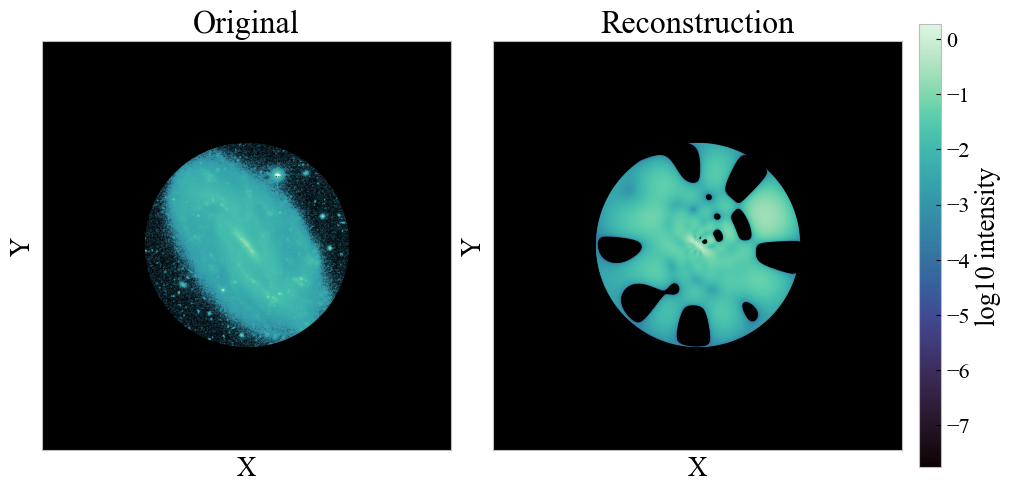

KeyboardInterrupt: 

<Figure size 900x600 with 0 Axes>

In [3]:
import os
from matplotlib.backends.backend_pdf import PdfPages

def galaxy_morphology(file):
    
    def FindInc2(eta, A, B, C, D):
        
        if eta>0.5:
            inc=90
        else:
            # 1) Safe inverse argument (A can be negative)
            x = np.clip((eta - D) / A, -1.0, 1.0)

            # 2) Two branches from cos symmetry, all in radians
            a = np.arccos(x)                # in [0, pi]
            i1 = (a - C) / B
            i2 = (-a - C) / B

            # 3) Convert candidates to degrees
            cand = np.rad2deg(np.array([i1, i2]))

            # 4) Reduce by the period in degrees: P = 2π/|B| (then to degrees)
            P = np.rad2deg(2*np.pi / abs(B))
            cand = cand % P                 # map into one period

            # 5) Fold into [0, 180], then reflect >90 across 90 to get [0, 90]
            cand = np.where(cand > 180.0, cand - 180.0, cand)
            cand = np.where(cand > 90.0, 180.0 - cand, cand)

            # 6) Pick the candidate that best reproduces eta (keeps you on the line)
            def model(i_deg):
                return A*np.cos(B*np.deg2rad(i_deg) + C) + D

            errs = np.abs(model(cand) - eta)
            inc=float(cand[np.argmin(errs)])
        return inc
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    radius=h//4
    cx, cy = w//2, h//2
    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)
    x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
    y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    # Filter for positive intensities and R <= 80
    valid = (I > 0) & (R <= 80)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5


    x_edges = np.asarray(x_edges).ravel()
    y_edges = np.asarray(y_edges).ravel()

    if x_edges.size < 2 or y_edges.size < 2:
        raise ValueError("Need at least two edges along each axis.")

    # If reversed (common for image-style Y axes), flip them:
    if x_edges[0] > x_edges[-1]:
        x_edges = x_edges[::-1]
    if y_edges[0] > y_edges[-1]:
        y_edges = y_edges[::-1]

    # If they’re not strictly increasing (duplicates), uniquify & sort:
    x_edges = np.unique(x_edges)
    y_edges = np.unique(y_edges)
    D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
    D.img       = gray
    D.x_edges   = x_edges
    D.y_edges   = y_edges
    D.x_centers = x_centers
    D.y_centers = y_centers

    mmax, nmax = 8, 10
    E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)
    
    c1 = E1.coscoefs; s1 = E1.sincoefs
   
    num = np.sqrt(sum((c1[2, n]**2 + s1[2, n]**2) for n in range(nmax)))
    den     = sum(abs(c1[0,n])            for n in range(nmax))

    eta_bt     = num/den

    
    A=-0.30845928737374684
    B=-1.6564105427131928
    C=6.430938401182824

    D=0.3145522357466893
    inc_bt=FindInc2(eta_bt,A,B,C,D)

    PA=(np.arctan2(s1[2,0],c1[2,0])* 180/np.pi)/2

    return  inc_bt, PA, galaxy_name,eta_bt
eta=[]
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('gfits3/*.fits.fz')



file=fits_files[33]

A=galaxy_morphology(file)
Name.append(A[2])
Inc.append(A[0])
PA.append(A[1])
eta.append(A[3])

print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}, eta={A[3]:.2f}")

with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
galaxy_name = file.split("-")[0]
h, w = image_data.shape

gray=image_data.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')

R = np.sqrt(X2**2 + Y2**2).ravel()
I = image_data.ravel()

# Filter for positive intensities and R <= 80
valid = (I > 0) & (R <= 80)
R_valid = R[valid]
logI_valid = np.log(I[valid])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
scale_length = -1 / slope
if scale_length < 0:
    scale_length = 50
if scale_length > 100:
    scale_length = 30

a=scale_length*1.5


x_edges = np.asarray(x_edges).ravel()
y_edges = np.asarray(y_edges).ravel()

if x_edges.size < 2 or y_edges.size < 2:
    raise ValueError("Need at least two edges along each axis.")

# If reversed (common for image-style Y axes), flip them:
if x_edges[0] > x_edges[-1]:
    x_edges = x_edges[::-1]
if y_edges[0] > y_edges[-1]:
    y_edges = y_edges[::-1]

# If they’re not strictly increasing (duplicates), uniquify & sort:
x_edges = np.unique(x_edges)
y_edges = np.unique(y_edges)
D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
D.img       = gray  
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

mmax, nmax = 8, 10
E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)

img_orig = D.img.copy()



# --- Laguerre expansion & reconstruction on the same grid ---
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T  # to match imshow orientation


# --- Plot side by side ---
cmap = sns.color_palette("mako", as_cmap=True)
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
recon_img = np.where(mask*1.2, recon_img, 0.0)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))
x_edges = np.linspace(-rmaxx, rmaxx, nbins + 1)
y_edges = np.linspace(-rmaxy, rmaxy, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
N=1000000
D = DiscGalaxy(N=N, a=a*1.5, M=np.sum(gray))
D.rotate_disc(62.32, 0, 90+35.82)   # inc=50, PA=45
D.generate_image(rmax=rmaxx, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
origdisc_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
fig1, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/fourierexp3319.pdf') as pp:
    for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
        h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
        ax.set_title(title)
        ax.set(facecolor="black")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("X"); ax.set_ylabel("Y")

    cbar = fig1.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
    cbar.set_label("log10 intensity")

    # Save into the PDF
    pp.savefig(fig1)

plt.show()

incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 180, 20)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
h=212
w=212
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees

plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=np.sum(gray))
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom   = sum(abs(coscoefs[0, n]) for n in range(nmax)) or np.nan
        num     = np.sqrt(sum((coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax)))
        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        eta_cos=90-(np.arctan2(sincoefs[2,0],coscoefs[2,0])* 180/np.pi)/2

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    
    
def cos_function(x_deg, A, B, C, D):
    return A * np.cos(B * np.radians(x_deg) + C) + D


inc_fit = np.linspace(0.0, 90.0, 500)
A=-0.30845928737374684
B=-1.6564105427131928
C=6.430938401182824

D=0.3145522357466893

eta_fit = cos_function(inc_fit, A, B, C, D)

plt.figure(figsize=(8, 5))
plt.plot(inc_fit, eta_fit, label=rf'Fit {A:.1f}$\cos$({B:.1f}$x$ + {C:.1f}) + {D:.1f}', linewidth=2, color=my_gradient(0.95))
plt.scatter(incl_list, eta_avg_list, label=r'Model $\eta$ and Inclination', color=my_gradient(0))
plt.scatter(Inc[0], eta[0], label='Blind-test from image', color='red', s=100, edgecolor='black', zorder=5)

plt.xlabel(r'Inclination (deg)')
plt.ylabel(r'$\eta$')
plt.title(r'Cosine Fit to $\eta$ vs Inclination')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

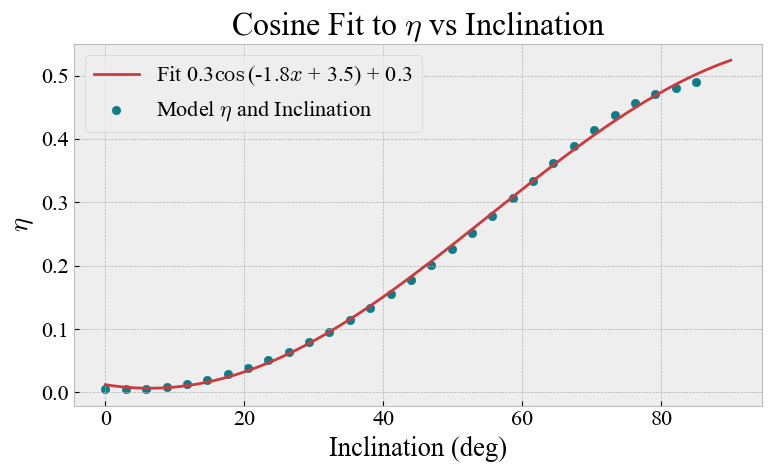

In [ ]:
def cos_function(x_deg, A, B, C, D):
    return A * np.cos(B * np.radians(x_deg) + C) + D


inc_fit = np.linspace(0.0, 90.0, 500)
A=0.27262716014051763
B=-1.8397445743459468
C=3.3452301250356076
D=0.27926458537922233

eta_fit = cos_function(inc_fit, A, B, C, D)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/InclFit.pdf') as pp:
    plt.figure(figsize=(8, 5))
    plt.plot(inc_fit, eta_fit, label=rf'Fit {A:.1f}$\cos$({B:.1f}$x$ + {3.5:.1f}) + {D:.1f}', linewidth=2, color=my_gradient(0.95))
    plt.scatter(incl_list, eta_avg_list, label=r'Model $\eta$ and Inclination', color=my_gradient(0))
    #plt.scatter(62.32,0.34, label='Fit for NGC3319', color='red', s=100, edgecolor='black', zorder=5)

    plt.xlabel(r'Inclination (deg)')
    plt.ylabel(r'$\eta$')
    plt.title(r'Cosine Fit to $\eta$ vs Inclination')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pp.savefig()
plt.show()

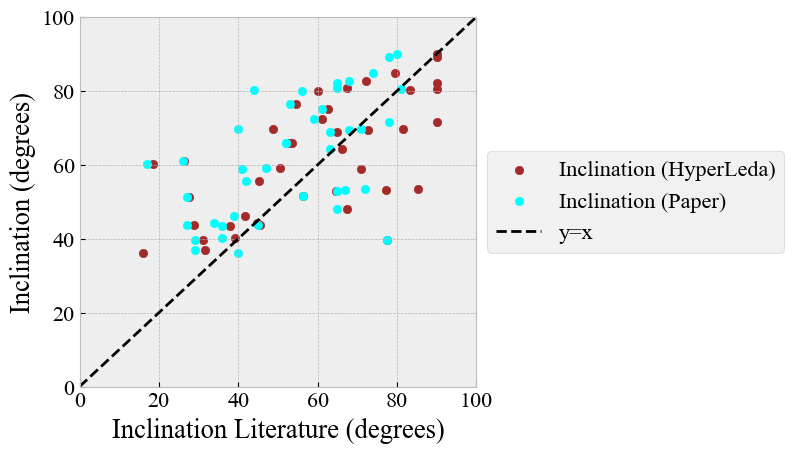

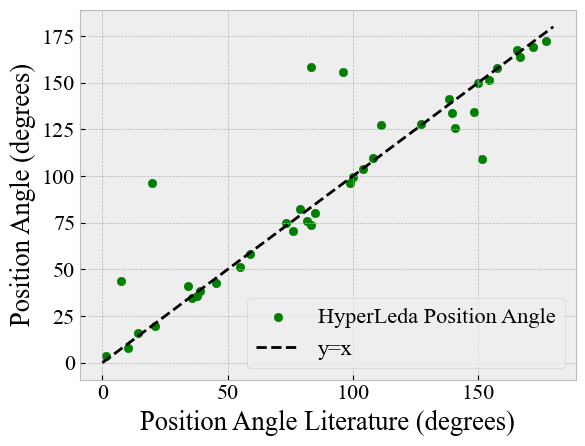

In [21]:
incl = [
    21.54, 38.55, 31.16, 39.33, 73.36, 76.26, 32.85, 53.95, 28.27, 109.75,
    31.55, 27.24, 36.88, 61.25, 73.60, 23.08, 109.75, 57.04, 36.95, 73.03,
    92.74, 109.75, 28.86, 79.60, 54.04, 39.20, 79.38, 37.78, 41.53, 81.25,
    32.77, 109.75, 37.98, 52.61, 109.75, 54.75, 60.89, 45.16, 25.94, 57.67,
    62.91
]
incl_a200 = [
    17.11, 24.35, 41.26, 33.68, 60.17, 69.92, 26.52, 52.17, 6.95, 90.36,
    41.92, 37.20, 45.08, 55.28, 59.07, 27.92, 98.86, 63.03, 26.89, 83.35,
    82.63, 91.20, 25.49, 75.96, 48.68, 32.75, 63.31, 31.43, 46.88, 65.08,
    56.23, 109.75, 43.69, 49.13, 109.75, 63.21, 53.01, 53.64, 39.06, 55.26,
    48.32
]

values = [
    19.82, 29.11, 24.70, 30.70, 66.50, 64.39, 26.50, 43.07, 25.02, 62.29,
    31.18, 25.01, 32.72, 46.67, 65.04, 24.50, 90.00, 43.31, 29.81, 48.75,
    66.02, 90.00, 25.80, 77.28, 43.66, 30.66, 57.64, 29.65, 36.49, 59.70,
    32.27, 78.71, 32.60, 45.27, 90.00, 51.15, 48.81, 40.13, 27.10, 53.52,
    51.70
]

paper_incl = [
    65, 42, 36, 36, 71, 78, 29, 59, 40, 61,
    56.3, 77.6, 27, 26, 68, 29, 65, 47, 27, 40,
    74, 81, 65, 53, 17, 39, 63, 45, 65, 52,
    72, 78, 67, 63, 80, 68, 44, 41, 34, 52,
    56
]

hyperleda_incl = [
    67.4, 45.2, 39.1, 37.9, 81.6, 90, 31.2, 61.1, 16.1, 62.7,
    56.3, 77.6, 27.7, 26.3, 72.1, 31.7, 67.5, 50.5, 28.9, 48.7,
    79.5, 90, 90, 54.5, 18.6, 41.7, 64.8, 45.4, 64.6, 53.6,
    85.3, 90, 77.2, 66.2, 90, 72.7, 83.3, 71, 44.8, 52.7,
    60.1
]
Inc = [
    47.99,
    55.68,
    40.11,
    43.52,
    69.75,
    71.63,
    39.66,
    72.34,
    36.24,
    75.17,
    51.44,
    39.76,
    51.26,
    61.06,
    82.62,
    36.84,
    80.87,
    59.06,
    43.79,
    69.76,
    84.95,
    80.53,
    82.16,
    76.38,
    60.14,
    46.06,
    68.86,
    43.83,
    52.99,
    65.79,
    53.45,
    89.17,
    53.14,
    64.17,
    89.87,
    69.45,
    80.37,
    58.77,
    44.35,
    65.77,
    79.99
]

pa = [
    127.42, 96.1, 158.45, 172.61, 103.76, 38.39, 109.37, 43.62, 4.16, 35.9,
    141.5, 51.35, 19.92, 70.78, 74.64, 125.64, 82.5, 15.69, 155.55, 133.96,
    163.58, 167.31, 8.14, 109.7, 147.64, 80.02, 134.47, 34.94, 169.05, 127.71,
    99.43, 149.76, 41, 42.79, 75.95, 3.71, 73.73, 58.08, 151.32, 157.8,
    96.29
]

hyperleda_pa = [
    111.3, 20, 83.4, 177, 104.1, 39, 151.7, 7.5, None, 37.7,
    138.5, 55, 21.2, 75.9, 73.4, 140.9, 79, 14.2, 95.9, 139.4,
    166.8, 165.6, 10.2, 107.9, None, 84.9, 148.3, 35.7, 171.8, 127,
    100, 150, 34, 45.5, 81.7, 1.5, 83.3, 58.9, 154.5, 157.4,
    98.8
]

sqrt_sum_a200 = [
    30.22, 25.75, 16.38, 20.36, 0.79, 6.15, 24.76, 8.80, 34.14, 82.19,
    14.98, 18.33, 12.52, 7.57, 1.35, 23.95, 52.79, 3.86, 24.78, 84.69,
    79.31, 72.17, 24.56, 84.81, 11.51, 19.67, 82.27, 16.22, 8.94, 4.65,
    5.35, 61.81, 10.67, 5.39, 66.22, 0.78, 7.57, 6.34, 13.36, 2.82,
    7.57
]

sqrt_sum_aa = [
    27.31, 17.29, 21.55, 16.47, 74.23, 77.21, 20.15, 3.72, 23.22, 77.99,
    15.50, 21.23, 12.91, 0.69, 77.03, 21.97, 66.22, 2.13, 17.83, 5.16,
    72.12, 52.62, 22.08, 64.77, 3.90, 16.33, 84.87, 16.73, 9.69, 81.09,
    13.63, 59.82, 13.16, 0.15, 66.22, 5.26, 1.58, 6.41, 19.09, 6.96,
    4.57
]
newcoeffs = [
    19.82,
    29.11,
    24.70,
    30.70,
    66.50,
    64.39,
    26.50,
    43.07,
    25.02,
    62.29,
    31.18,
    25.01,
    32.72,
    46.67,
    65.04,
    24.50,
    90.00,
    43.31,
    29.81,
    48.75,
    66.02,
    90.00,
    25.80,
    77.28,
    43.66,
    30.66,
    57.64,
    29.65,
    36.49,
    59.70,
    32.27,
    78.71,
    32.60,
    45.27,
    90.00,
    51.15,
    48.81,
    40.13,
    27.10,
    53.52,
    51.70
]

values2 = [
    20.30,
    29.30,
    25.02,
    30.84,
    66.68,
    64.44,
    26.77,
    42.91,
    25.33,
    62.24,
    31.31,
    25.33,
    32.80,
    46.46,
    65.13,
    24.83,
    90.00,
    43.14,
    29.97,
    48.51,
    66.17,
    90.00,
    26.09,
    78.86,
    43.49,
    30.80,
    57.46,
    29.82,
    36.46,
    59.57,
    32.36,
    80.63,
    32.69,
    45.08,
    90.00,
    50.91,
    48.58,
    40.02,
    27.35,
    53.29,
    51.46
]


x=np.linspace(0, 180, 100)
fig = plt.figure()
ax = plt.subplot(111)
""" plt.scatter(paper_incl, incl, label='Paper Inclination', color='blue')
plt.scatter(hyperleda_incl, incl, label='HyperLeda Inclination', color='orange')
plt.scatter(hyperleda_incl, incl_a200, label='Inclination a=200', color='red')
plt.scatter(paper_incl, incl_a200, label='Inclination( Paper)', color='purple')"""
plt.scatter(hyperleda_incl, Inc, label='Inclination (HyperLeda)', color='brown')
plt.scatter(paper_incl,Inc, label='Inclination (Paper)', color='cyan')
plt.plot(x, x, color='black', linestyle='--', label='y=x')
plt.xlabel('Inclination Literature (degrees)')
plt.ylabel('Inclination (degrees)')
plt.xlim(0, 100)
plt.ylim(0, 100)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.scatter(hyperleda_pa, pa, label='HyperLeda Position Angle', color='green')
plt.plot(x, x, color='black', linestyle='--', label='y=x')
plt.xlabel('Position Angle Literature (degrees)')
plt.ylabel('Position Angle (degrees)')
plt.legend()
plt.show()  

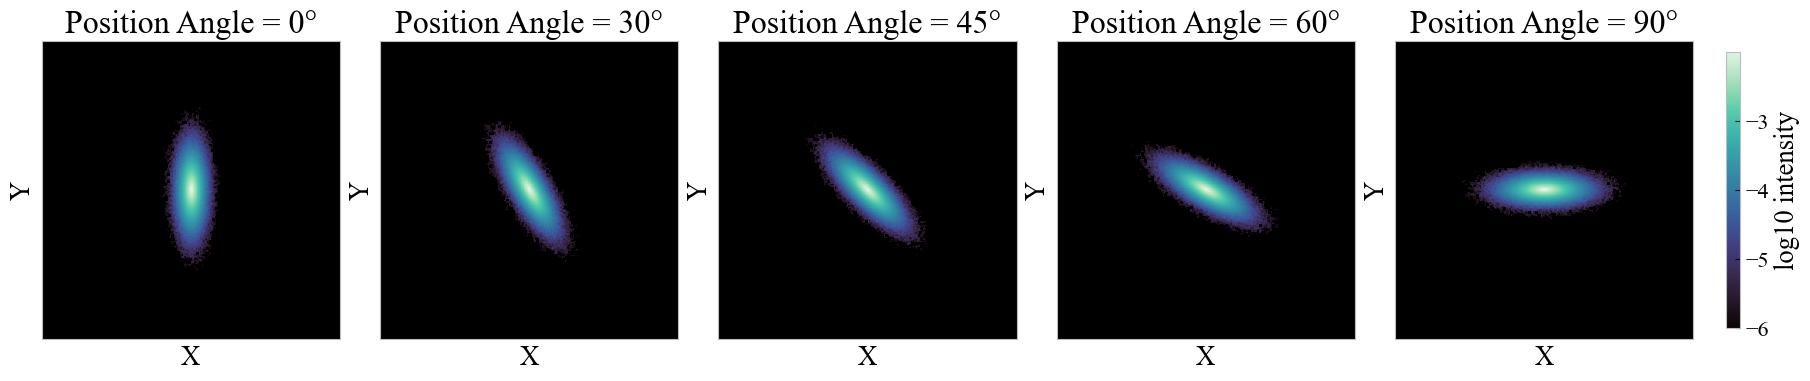

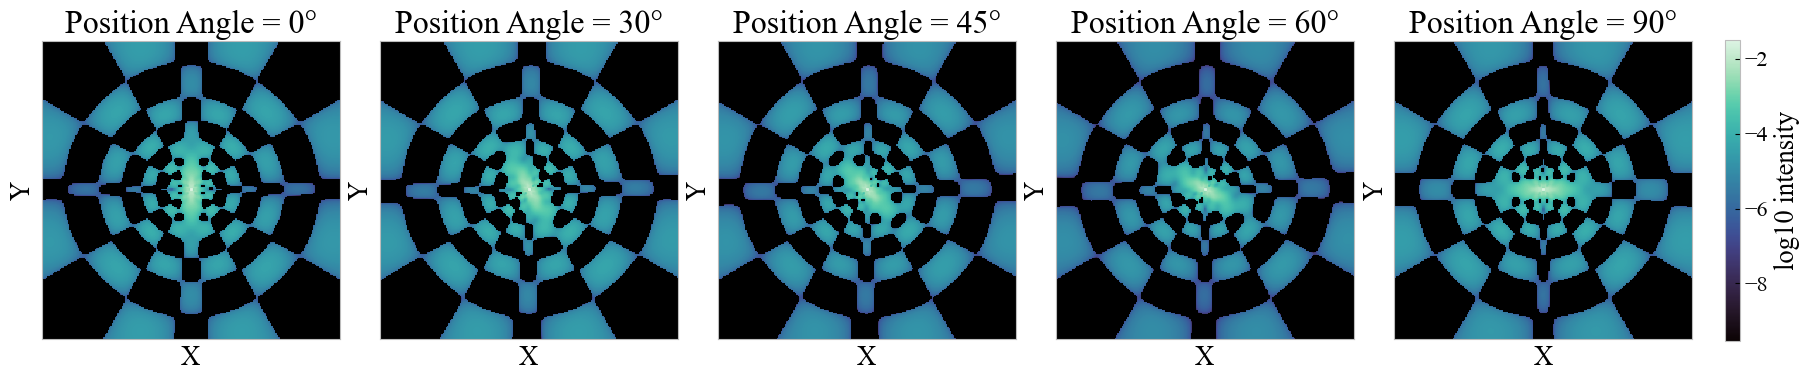

Amn (rows = n, columns = m):
[[114.   2.  12.   2.   2.   1.   1.]
 [  7.   1.   4.   2.   3.   0.   2.]
 [  0.   1.   1.   1.   3.   0.   1.]
 [  1.   1.   2.   0.   2.   1.   1.]
 [  0.   1.   2.   1.   1.   2.   2.]
 [  0.   1.   3.   2.   1.   2.   3.]
 [  0.   1.   2.   2.   1.   2.   4.]
 [  1.   1.   2.   2.   1.   2.   4.]]


In [ ]:
import seaborn as sns
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees

# precompute grid edges/centers + extent
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

orig_imgs = []
recon_imgs = []

for PA in PAs:
    # --- simulate & get original image ---
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(70, 0, 90+PA)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    orig_imgs.append(img_orig)

    # --- Laguerre expansion & reconstruction on the same grid ---
    E1 = D.make_expansion(mmax, nmax, a, noisy=False)
    E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

    # Map reconstruction back to the image grid via histogramming
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    x_flat = X2.ravel()
    y_flat = Y2.ravel()
    w_flat = E1.reconstruction.ravel()

    recon_img, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges],
        weights=w_flat
    )
    counts, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges]
    )

    # avoid divide-by-zero; normalize total flux to the original image
    recon_img = recon_img / np.maximum(counts, 1)
    # match total intensity
    total_recon = np.sum(recon_img)
    if total_recon > 0:
        recon_img *= np.sum(img_orig) / total_recon

    recon_img = recon_img.T  # to match imshow orientation
    recon_imgs.append(recon_img)

cmap=sns.color_palette("mako", as_cmap=True)
# --- plot: originals ---
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/PAs.pdf') as pp:
    fig1, axes1 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
    for ax in axes1:
        ax.set(facecolor = "black")
    if len(incs) == 1:
        axes1 = [axes1]
    for ax, inc, im in zip(axes1, incs, orig_imgs):
        imshow_data = np.log10(np.where(im > 0, im, np.nan))
        h = ax.imshow(imshow_data, extent=extent, cmap=cmap, origin='lower')
        ax.set_title(f"Position Angle = {inc}°")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("X"); ax.set_ylabel("Y")

    cbar1 = fig1.colorbar(h, ax=axes1, shrink=0.9, pad=0.02)
    cbar1.set_label("log10 intensity")
    pp.savefig(fig1)
plt.show()
# --- plot: reconstructions (a = 60) ---
fig2, axes2 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes2:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes2 = [axes2]
for ax, inc, im in zip(axes2, incs, recon_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data.T, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")


cbar2 = fig2.colorbar(h, ax=axes2, shrink=0.9, pad=0.02)
cbar2.set_label("log10 intensity")

plt.show()
nmax=8
mmax=6
N=10000
a=6
D = DiscGalaxy(N=N, a=a, M=3951.4895 )
D.rotate_disc(30, 0, 40)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E = D.make_pointexpansion(mmax, nmax, a, noisy=False)
E.laguerre_reconstruction(D.r, D.p)



coscoefs = E.coscoefs
sincoefs = E.sincoefs

Amn = np.sqrt(E.coscoefs**2 + E.sincoefs**2) 

Amn_matrix = Amn.T 

# Print matrix
print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,0)) 





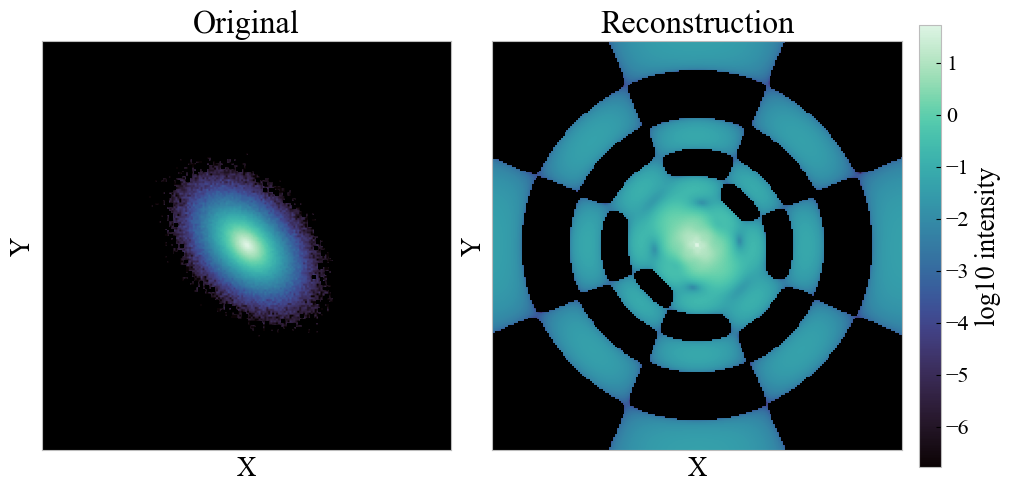

In [ ]:
# parameters
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 6, 10
# generate galaxy
D = DiscGalaxy(N=N, a=a, M=3951.4895)
D.rotate_disc(50, 0, 90+45)   # inc=50, PA=45
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

# Map reconstruction back to the image grid via histogramming
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = X2.ravel()
y_flat = Y2.ravel()
w_flat = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)

# avoid divide-by-zero; normalize total flux to the original image
recon_img = recon_img / np.maximum(counts, 1)
# match total intensity
total_recon = np.sum(recon_img)
if total_recon > 0:
    recon_img *= np.sum(img_orig) / total_recon

recon_img = recon_img.T  # to match imshow orientation
recon_imgs.append(recon_img)

# --- Plot side by side ---
cmap = sns.color_palette("mako", as_cmap=True)
orig_log = np.log10(np.where(img_orig > 0, img_orig, np.nan))
recon_log = np.log10(np.where(recon_img > 0, recon_img, np.nan))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

for ax, im, title in zip(axes, [orig_log, recon_log], ["Original", "Reconstruction"]):
    h = ax.imshow(im, extent=extent, cmap=cmap, origin="lower")
    ax.set_title(title)
    ax.set(facecolor = "black")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar = fig.colorbar(h, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label("log10 intensity")

plt.show()


<>:137: SyntaxWarning: invalid escape sequence '\e'
<>:137: SyntaxWarning: invalid escape sequence '\e'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_94341/3846659651.py:137: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.005284220604786949, xmax=0.005284220604787004, xval=0.04833222230888523). Clipping it into the allowed range.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.005280935178788526, xmax=0.005280935178788526, xval=0.08555560594102127). Clipping it into the allowed range.
  warnings.warn(
/Library/Framew

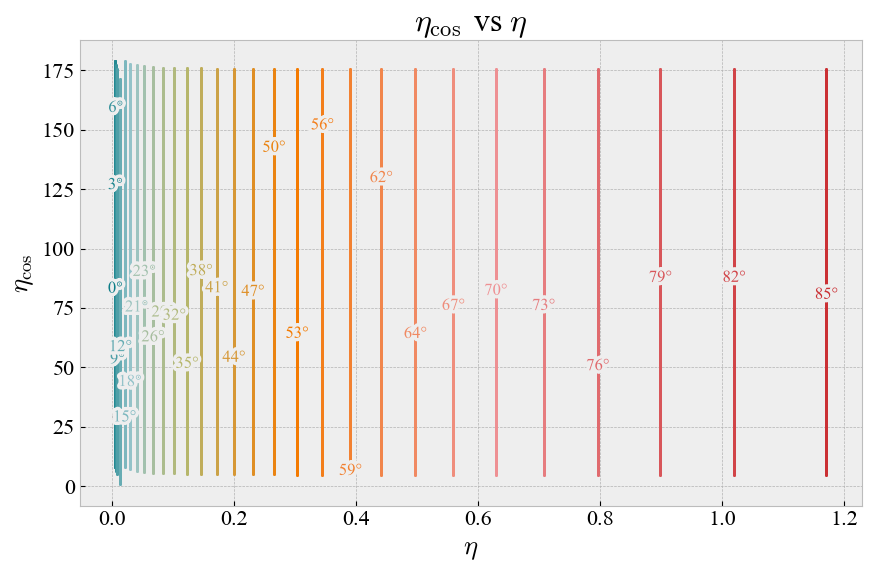


=== Cosine + Exponential Fit ===
A = -1.9953 ± 6.4738
B = -0.6074 ± 0.9884
C = 6.3229 ± 0.0719
D = 2.0000 ± 6.4746
E = 0.0005 ± 0.0007
F = 0.0795 ± 0.0117
RMSE = 0.0015


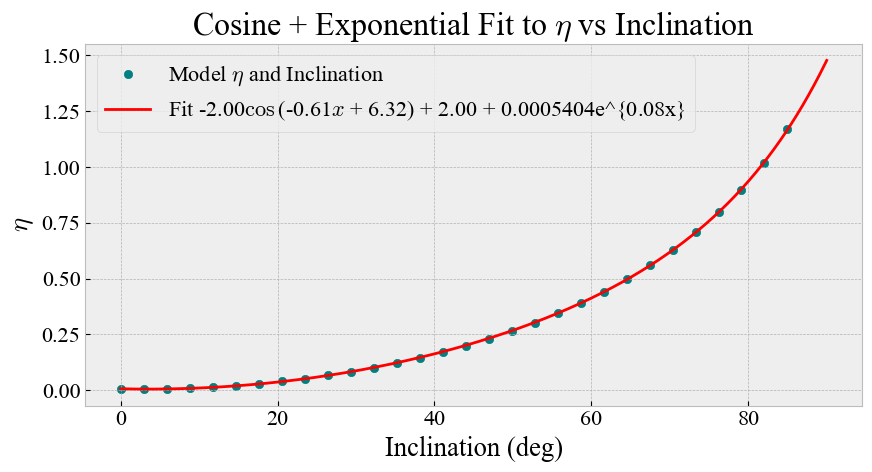

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 180, 20)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
h=212
w=212
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
D = DiscGalaxy(N=N, a=a,M=3951.4895 )
D.rotate_disc(40, 0, 9)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

gray=img_orig.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')


plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=3333)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom = np.sqrt(np.sum([coscoefs[0, n]**2 for n in range(nmax)]))
        denom = denom if denom != 0.0 else np.nan

        # Numerator: combined magnitude of m=2 cosine+sin coefficients
        num = np.sqrt(np.sum([coscoefs[2, n]**2 + sincoefs[2, n]**2 for n in range(nmax)]))

        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        eta_cos=90-(np.arctan2(sincoefs[2,0],coscoefs[2,0])* 180/np.pi)/2

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(etas, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))

plt.xlabel(r"$\eta$")
labelLines(plt.gca().get_lines(), align=False, fontsize=12)
plt.ylabel(r"$\eta_{\cos}$")
plt.title(r"$\eta_{\cos}$ vs $\eta$")
plt.grid(True)
plt.tight_layout()
plt.show()
# ================================================
# 1) Define improved model: Cosine + Exponential
# ================================================
def cos_plus_exp(x_deg, A, B, C, D, E, F):
    """
    A * cos(B * radians(x) + C) + D + E * exp(F * x)
    Combines an oscillatory term with a rising exponential tail.
    """
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D + E * np.exp(F * x_deg)


# ================================================
# 2) Initial guesses and bounds
# ================================================
p0 = [-0.3, -1.65, 6.43, 0.32, 0.01, 0.05]

lower = [-2.0, -10.0, -10.0, -1.0, -10.0, -1.0]
upper = [ 2.0,  10.0,  10.0,  2.0,  10.0,  1.0]

params, covariance = curve_fit(
    cos_plus_exp, xdata, ydata,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000
)

A_fit, B_fit, C_fit, D_fit, E_fit, F_fit = params
errors = np.sqrt(np.diag(covariance))

print("\n=== Cosine + Exponential Fit ===")
print(f"A = {A_fit:.4f} ± {errors[0]:.4f}")
print(f"B = {B_fit:.4f} ± {errors[1]:.4f}")
print(f"C = {C_fit:.4f} ± {errors[2]:.4f}")
print(f"D = {D_fit:.4f} ± {errors[3]:.4f}")
print(f"E = {E_fit:.4f} ± {errors[4]:.4f}")
print(f"F = {F_fit:.4f} ± {errors[5]:.4f}")

# ================================================
# 4) Generate fit curve for plotting
# ================================================
inc_fit = np.linspace(0, 90, 500)
eta_fit = cos_plus_exp(inc_fit, *params)

# Compute residuals and RMSE for diagnostics
residuals = ydata - cos_plus_exp(xdata, *params)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.4f}")

# ================================================
# 5) Plot results
# ================================================
plt.figure(figsize=(9, 5))
plt.scatter(incl_list, eta_avg_list, color='teal', label='Model $\eta$ and Inclination')
plt.plot(inc_fit, eta_fit, 'r-', lw=2,
         label=rf'Fit {A_fit:.2f}$\cos$({B_fit:.2f}$x$ + {C_fit:.2f}) + {D_fit:.2f} + {E_fit:.7f}e^{{{F_fit:.2f}x}}')

plt.xlabel('Inclination (deg)')
plt.ylabel(r'$\eta$')
plt.title(r'Cosine + Exponential Fit to $\eta$ vs Inclination')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from scipy.optimize import root_scalar
import numpy as np

def cos_plus_exp(x_deg, A, B, C, D, E, F):
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C) + D + E * np.exp(F * x_deg)


def find_inclination_from_eta(eta_target, A, B, C, D, E, F, 
                              search_range=(0, 90), tol=1e-6, verbose=False):
    """
    Numerically invert the cosine+exponential fit.
    Returns inclination angle (deg) for a given η value.
    """

    def f(x):
        return cos_plus_exp(x, A, B, C, D, E, F) - eta_target

    # Check range validity
    x_min, x_max = search_range
    fmin, fmax = f(x_min), f(x_max)
    if np.sign(fmin) == np.sign(fmax):
        if verbose:
            print("⚠️ Eta target is outside model range, extrapolating.")
        # fall back to best-fit (minimization)
        x_grid = np.linspace(x_min, x_max, 2000)
        vals = np.abs(f(x_grid))
        return x_grid[np.argmin(vals)]

    sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
    if not sol.converged:
        raise RuntimeError("Root finding failed to converge.")
    return sol.root



In [10]:


from flex import FLEX

from scipy.stats import linregress
from astropy.io import fits
from astropy.wcs import WCS

import numpy as np


from scipy.optimize import root_scalar
    
def galaxymorphology(file,galaxy=None,data=None,noisefloor=-5.):

    if data is not None and galaxy is None:
        raise ValueError("If 'data' is provided, 'galaxy' must also be defined.")
    
    def cos_plus_exp(x_deg, A, B, D, E, F):
        x_rad = np.deg2rad(x_deg)
        
        return A * np.cos(B * x_rad) + D + E * np.exp(F * x_deg)


    def find_inclination_from_eta(eta_target, A, B, D, E, F, 
                                search_range=(0, 90), tol=1e-6, verbose=False):
        """Numerically invert the cosine+exponential fit."""
        def f(x):
            return cos_plus_exp(x, A, B, D, E, F) - eta_target

        x_min, x_max = search_range
        fmin, fmax = f(x_min), f(x_max)
        if np.sign(fmin) == np.sign(fmax):
            if verbose:
                print("⚠️ Eta target is outside model range, extrapolating.")
            x_grid = np.linspace(x_min, x_max, 2000)
            vals = np.abs(f(x_grid))
            return x_grid[np.argmin(vals)]

        sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
        if not sol.converged:
            raise RuntimeError("Root finding failed to converge.")
        return sol.root
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data

        if data is not None:
            ra = data['RA_LEDA'][data['GALAXY']==galaxy]
            dec = data['DEC_LEDA'][data['GALAXY']==galaxy]

            wcs = WCS(hdulist[1].header)
            pixel_coords = wcs.world_to_pixel_values(ra, dec)
            #print("Pixel coordinates (x, y):", pixel_coords)
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    # this choice of radius is a hyperparameter -- we may want to tune it
    radius=h//4

    if data is None:
        cx, cy = w//2, h//2
    else:   
        cx, cy = pixel_coords[0], pixel_coords[1]


    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)

    X2,Y2 = (y-cx), (x-cy)

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    valid = (I > 0) & (R <= radius)
    R_valid = R[valid]
    I_valid = I[valid]
    #print(y,x)

    rindx = R_valid.argsort()
    R_sorted = R_valid[rindx]
    I_sorted = I_valid[rindx]

    # generate a moving average
    window_size = 100 # this is a hyperparameter
    means_R = np.convolve(R_sorted, np.ones(window_size)/window_size, mode='valid')
    means_I = np.convolve(I_sorted, np.ones(window_size)/window_size, mode='valid')
    
    # set the floor for noise
    # if this fails ... use outermost radius
   
    indices_below_noise = np.where(np.log(np.clip(means_I, 1e-10, None)) < noisefloor)[0]
    if len(indices_below_noise) > 0:
        maxrad = means_R[indices_below_noise[0]]
    else:
        maxrad = means_R[-1]
    
    valid = (I > 0) & (R <= maxrad)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5

    R,P = np.sqrt(X2**2 + Y2**2), np.arctan2(Y2, X2)

    mmax, nmax = 8, 10


    L = FLEX(a,mmax,nmax, R.flatten(), P.flatten(), mass=image_data.flatten())
    
    c1 = L.coscoefs; s1 = L.sincoefs
   
    num = np.linalg.norm(np.sqrt(L.coscoefs[2]**2 + L.sincoefs[2]**2))
    den = np.linalg.norm(L.coscoefs[0])

    eta_bt     = num/den
    
    A_fit = -1.9953 
    B_fit = -0.6074 
    D_fit = 2.0000 
    E_fit = 0.0005
    F_fit = 0.0795 
    
    inc_bt=find_inclination_from_eta(eta_bt,A_fit,B_fit,D_fit,E_fit,F_fit,verbose=True)
    
    phi=np.arctan2(s1[2,0],c1[2,0])
  
    if phi < 0 :
        phi= -np.pi - 1*phi
    else:
        phi=np.pi- 1*phi 
    PA=90+(phi* 180/np.pi)/2
  
    return inc_bt, PA, galaxy_name, a, eta_bt, maxrad, radius


    


In [11]:
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('data/gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxymorphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])
    print(f"Processed {A[2]}: Inc={A[0]:.2f}, PA={A[1]:.2f}")

Processed data/gfits3/NGC5289: Inc=50.40, PA=99.16
Processed data/gfits3/NGC6186: Inc=55.94, PA=57.44
Processed data/gfits3/NGC3310: Inc=32.79, PA=4.93
Processed data/gfits3/NGC2893: Inc=36.72, PA=160.33
Processed data/gfits3/NGC2776: Inc=44.78, PA=130.36
Processed data/gfits3/NGC4203: Inc=80.74, PA=4.40
Processed data/gfits3/NGC5676: Inc=61.61, PA=41.85
Processed data/gfits3/NGC4369: Inc=57.38, PA=147.87
Processed data/gfits3/NGC4100: Inc=83.70, PA=163.77
Processed data/gfits3/NGC5112: Inc=63.32, PA=127.00
Processed data/gfits3/NGC3726: Inc=56.25, PA=20.91
Processed data/gfits3/NGC4359: Inc=74.58, PA=109.78
Processed data/gfits3/NGC3556: Inc=79.36, PA=79.64
Processed data/gfits3/NGC6217: Inc=41.04, PA=151.65
Processed data/gfits3/NGC3403: Inc=81.22, PA=74.51
Processed data/gfits3/NGC6140: Inc=78.83, PA=62.88
Processed data/gfits3/NGC3118: Inc=69.52, PA=38.25
Processed data/gfits3/NGC4051: Inc=67.53, PA=140.02
Processed data/gfits3/NGC2985: Inc=40.19, PA=165.59
Processed data/gfits3/NG